## Imports

In [1382]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

nltk.download('words')

[nltk_data] Downloading package words to /Users/olive/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Load Data

In [1383]:
DATA_PATH = '/Users/olive/github/fantasynba/data/projections.xlsx'

nba = pd.read_excel(DATA_PATH)

nba[:10]

,R#,PLAYER,POS,TEAM,GP,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,TOTAL
0,1,James Harden The departure Of Capela has resul...,"PG,SG",HOU,78,36.0,0.45 (9.6/21.4),0.88 (8.9/10.1),4.8,32.9,5.8,7.2,2.0,0.8,4.3,15.80
1,2,Anthony Davis Has been battling injuries for m...,"PF,C",LAL,74,34.0,0.54 (9.4/17.6),0.84 (6.5/7.8),1.0,26.4,10.0,3.7,1.5,2.6,2.1,14.75
2,3,Nikola Jokic The buy-low window has well and t...,"PF,C",DEN,76,33.0,0.55 (9.2/16.7),0.82 (3.7/4.5),1.1,23.1,10.4,7.5,1.3,1.0,3.3,11.08
3,4,Damian Lillard Portland's playoff chances ride...,PG,POR,68,33.0,0.45 (9.2/20.1),0.90 (6.9/7.6),4.0,29.2,3.9,7.7,1.0,0.4,2.9,10.96
4,5,Kawhi Leonard A top 10 fantasy player in re-dr...,"SG,SF",LAC,68,30.0,0.47 (9.4/20.2),0.90 (5.7/6.3),2.3,26.8,6.8,5.1,1.7,0.8,2.3,10.84
5,6,"John Collins Sure, his rebounds and blocks tak...","PF,C",ATL,46,32.0,0.58 (10.1/17.4),0.82 (2.2/2.7),1.7,24.2,10.0,2.0,0.7,1.5,1.8,10.11
6,7,Jayson Tatum His FG% is trending in the right ...,"SF,PF",BOS,78,36.0,0.47 (10.2/21.7),0.83 (2.9/3.5),3.6,27.0,7.9,3.8,1.4,1.1,2.3,9.84
7,8,"Russell Westbrook Westbrook is back, and his s...",PG,HOU,76,36.0,0.50 (12.2/24.3),0.79 (5.6/7.1),0.7,30.7,8.7,6.5,2.0,0.4,4.4,9.71
8,9,Bradley Beal He's going to continue playing 35...,SG,WAS,78,36.0,0.46 (11.9/25.8),0.86 (5.5/6.5),3.6,32.8,4.0,6.2,1.5,0.4,4.4,9.48
9,10,Karl-Anthony Towns Minnesota finally managed t...,C,MIN,45,30.0,0.51 (8.4/16.3),0.80 (4.4/5.5),3.0,24.3,9.6,3.5,0.8,1.3,2.8,9.24


## Data preprocessing

In [1384]:
nba.drop('TOTAL', axis=1, inplace=True)
nba.drop('R#', axis=1, inplace=True)
nba.drop('GP', axis=1, inplace=True)
nba.drop('TEAM', axis=1, inplace=True)
#nba.drop('POS', axis=1, inplace=True)

In [1385]:
nba.isnull().any().any()

False

In [1386]:
words = set(nltk.corpus.words.words('en'))

def is_name(name):
    player_name = name.split()[:2]
    return ' '.join(player_name)
    
def remove_text_inside_brackets(text, brackets="()"):
    count = [0] * (len(brackets) // 2)
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: 
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close 
                if count[kind] < 0: 
                    count[kind] = 0  
                else: 
                    break
        else:
            if not any(count):
                saved_chars.append(character)
    return float(''.join(saved_chars))

In [1387]:
nba['PLAYER'] = nba['PLAYER'].apply(is_name)

nba['FG%'] = nba['FG%'].apply(remove_text_inside_brackets)
nba['FT%'] = nba['FT%'].apply(remove_text_inside_brackets)

nba.head()

,PLAYER,POS,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO
0,James Harden,"PG,SG",36.0,0.45,0.88,4.8,32.9,5.8,7.2,2.0,0.8,4.3
1,Anthony Davis,"PF,C",34.0,0.54,0.84,1.0,26.4,10.0,3.7,1.5,2.6,2.1
2,Nikola Jokic,"PF,C",33.0,0.55,0.82,1.1,23.1,10.4,7.5,1.3,1.0,3.3
3,Damian Lillard,PG,33.0,0.45,0.90,4.0,29.2,3.9,7.7,1.0,0.4,2.9
4,Kawhi Leonard,"SG,SF",30.0,0.47,0.90,2.3,26.8,6.8,5.1,1.7,0.8,2.3


In [1388]:
nba.shape

(200, 12)

In [1389]:
nba.mean()

MPG     28.4950
FG%      0.4755
FT%      0.7829
3PM      1.5490
PTS     15.1525
TREB     5.7515
AST      3.2190
STL      0.9705
BLK      0.6780
TO       1.8180
dtype: float64

# EDA

In [1390]:
#sns.pairplot(nba[["MPG", "FG%", "FT%", "3PM", "PTS", "AST", "STL", "BLK", "TO"]])

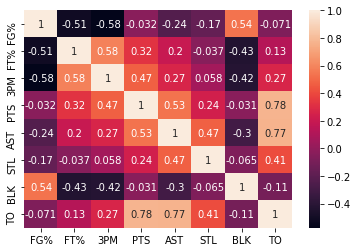

In [1391]:
correlation = nba[["FG%", "FT%", "3PM", "PTS", "AST", "STL", "BLK", "TO"]].corr()
sns.heatmap(correlation, annot=True)

# KMeans Clustering

In [1407]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Text(0, 0.5, 'Distortion')

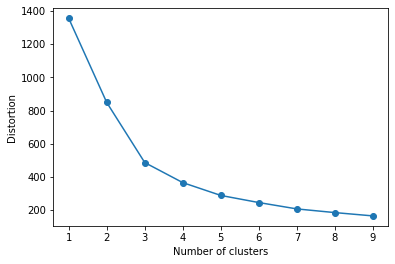

In [1408]:
scaler = StandardScaler()
X = nba._get_numeric_data().dropna(axis=1)
X_scaled = scaler.fit_transform(X)

pca_2 = PCA(2)
pca_2.fit(X_scaled)
X_pca = pca_2.transform(X_scaled)

distortions = []

for i in range(1, 10):
    km = KMeans(
        n_clusters=i, 
        init='random', 
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0)
    km.fit(X_pca)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

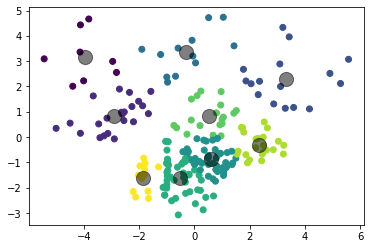

In [1426]:
kmeans_model = KMeans(n_clusters=9, 
                      init='random',
                      n_init=10,
                      max_iter=300,
                      tol=1e-04,
                      random_state=0)
kmeans_model.fit(X_pca)
labels = kmeans_model.labels_

centers = kmeans_model.cluster_centers_
plt.scatter(x = X_pca[:,0], y = X_pca[:,1], c = labels)
plt.scatter(x = centers[:, 0], y = centers[:, 1], c = 'black', s = 200, alpha = 0.5)

In [1427]:
nba['Cluster'] = kmeans_model.labels_
nba[:12]

,PLAYER,POS,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,Cluster
0,James Harden,"PG,SG",36.0,0.45,0.88,4.8,32.9,5.8,7.2,2.0,0.8,4.3,2
1,Anthony Davis,"PF,C",34.0,0.54,0.84,1.0,26.4,10.0,3.7,1.5,2.6,2.1,3
2,Nikola Jokic,"PF,C",33.0,0.55,0.82,1.1,23.1,10.4,7.5,1.3,1.0,3.3,3
3,Damian Lillard,PG,33.0,0.45,0.90,4.0,29.2,3.9,7.7,1.0,0.4,2.9,2
4,Kawhi Leonard,"SG,SF",30.0,0.47,0.90,2.3,26.8,6.8,5.1,1.7,0.8,2.3,2
5,John Collins,"PF,C",32.0,0.58,0.82,1.7,24.2,10.0,2.0,0.7,1.5,1.8,3
6,Jayson Tatum,"SF,PF",36.0,0.47,0.83,3.6,27.0,7.9,3.8,1.4,1.1,2.3,2
7,Russell Westbrook,PG,36.0,0.50,0.79,0.7,30.7,8.7,6.5,2.0,0.4,4.4,2
8,Bradley Beal,SG,36.0,0.46,0.86,3.6,32.8,4.0,6.2,1.5,0.4,4.4,2
9,Karl-Anthony Towns,C,30.0,0.51,0.80,3.0,24.3,9.6,3.5,0.8,1.3,2.8,6


In [1428]:
nba.mean()

MPG        28.4950
FG%         0.4755
FT%         0.7829
3PM         1.5490
PTS        15.1525
TREB        5.7515
AST         3.2190
STL         0.9705
BLK         0.6780
TO          1.8180
Cluster     4.2750
dtype: float64

In [1553]:
def get_cluster(val):
    return nba.loc[nba['Cluster'] == val]

print(get_cluster(5))
# print(get_cluster(3).mean())

                  PLAYER   MPG   FG%   FT%  3PM   PTS  TREB  AST  STL  BLK  \
66         Jaren Jackson  27.0  0.47  0.72  2.1  15.6   5.7  1.2  0.7  1.7   
102      Duncan Robinson  28.0  0.47  0.88  3.9  14.0   3.3  1.5  0.5  0.2   
107           OG Anunoby  30.0  0.50  0.69  1.4  11.3   6.3  1.1  1.2  0.6   
109        Rui Hachimura  29.0  0.47  0.86  0.5  13.5   5.5  1.6  0.9  0.7   
111             Naz Reid  23.0  0.44  0.77  1.5  13.8   6.6  1.8  0.7  1.1   
113      Lauri Markkanen  26.0  0.43  0.87  1.9  14.7   5.9  1.2  0.6  0.5   
119          Danny Green  25.0  0.42  0.84  2.0   8.8   3.8  1.5  0.8  1.3   
123         Danuel House  29.0  0.43  0.82  2.2  10.7   4.6  1.3  1.1  0.5   
126      Jordan Clarkson  25.0  0.48  0.86  1.7  16.8   3.2  2.3  0.6  0.2   
127            Josh Hart  22.0  0.45  0.76  1.4  10.0   5.8  1.8  1.2  0.5   
128          Bruce Brown  29.0  0.45  0.75  0.6   9.7   6.5  3.9  0.8  0.8   
130           Marc Gasol  24.0  0.41  0.75  1.1   9.4   6.5  3.6

## Organize players into clusters

In [1611]:
#nba.drop('POS', axis=1, inplace=True)

# Top similar players to a specified player
def top_similar_players_in_cluster(search, cluster_category, recommender_df, max_range):
    for player in cluster_category.loc[cluster_category['PLAYER'].str.contains(search), 'PLAYER']:
        return recommender_df[player].sort_values()[1:max_range]
        
def create_recommender(cluster):
    recommender = pairwise_distances(cluster, metric='cosine')
    recommender_df = pd.DataFrame(
        recommender,
        index = cluster.index,
        columns = cluster.index)
    return recommender_df

def show_data_for_similar_players(cluster, players = []):
    return get_cluster(cluster).loc[lambda df: df.PLAYER.isin(players)]

### Centers

In [1612]:
db = nba.loc[nba['Cluster'] == 0]

DEFENSIVE_BIGS = db.set_index(['PLAYER'])

In [1613]:
db_recommender = create_recommender(DEFENSIVE_BIGS)
db_recommender.head()

PLAYER,Hassan Whiteside,Mitchell Robinson,Rudy Gobert,Jonas Valanciunas,Steven Adams,Clint Capela,DeAndre Jordan,Jarrett Allen
PLAYER,,,,,,,,
Hassan Whiteside,0.000000,0.012466,0.004629,1.873713e-03,0.016870,0.004611,0.007165,0.010191
Mitchell Robinson,0.012466,0.000000,0.004387,9.872494e-03,0.004526,0.003282,0.012229,0.002879
Rudy Gobert,0.004629,0.004387,0.000000,2.117534e-03,0.004291,0.001302,0.003091,0.001197
Jonas Valanciunas,0.001874,0.009872,0.002118,4.440892e-16,0.011437,0.002200,0.005384,0.005947
Steven Adams,0.016870,0.004526,0.004291,1.143662e-02,0.000000,0.007177,0.006695,0.001312


In [1626]:
top_similar_players_in_cluster(
    search='Rudy Gobert', 
    cluster_category=db,
    recommender_df=db_recommender_df,
    max_range=4
)

PLAYER
Jarrett Allen        0.001197
Clint Capela         0.001302
Jonas Valanciunas    0.002118
Name: Rudy Gobert, dtype: float64

## All around threats

In [1615]:
at = nba.loc[nba['Cluster'] == 2]

ALL_AROUND_THREATS = at.set_index(['PLAYER'])

In [1616]:
at_recommender = create_recommender(ALL_AROUND_THREATS)
at_recommender.head()

PLAYER,James Harden,Damian Lillard,Kawhi Leonard,Jayson Tatum,Russell Westbrook,Bradley Beal,Trae Young,LeBron James,Jrue Holiday,Luka Doncic,Devin Booker,Kyle Lowry,Lonzo Ball,Zach LaVine,Donovan Mitchell,De'Aaron Fox
PLAYER,,,,,,,,,,,,,,,,
James Harden,0.000000,0.001368,2.767538e-03,8.759106e-03,0.005923,0.001178,0.003412,0.009933,0.029767,0.007365,0.009382,0.021819,0.057990,0.005648,0.007536,0.018974
Damian Lillard,0.001368,0.000000,4.991633e-03,1.088390e-02,0.008357,0.001639,0.001278,0.008957,0.025591,0.008924,0.007323,0.018343,0.054734,0.006062,0.007454,0.015952
Kawhi Leonard,0.002768,0.004992,2.220446e-16,4.698214e-03,0.001952,0.004452,0.008148,0.010232,0.028302,0.004512,0.010065,0.021730,0.053929,0.005414,0.006992,0.018088
Jayson Tatum,0.008759,0.010884,4.698214e-03,1.110223e-16,0.006205,0.010277,0.014496,0.013741,0.018110,0.010224,0.006639,0.014175,0.038590,0.002641,0.003002,0.011645
Russell Westbrook,0.005923,0.008357,1.951815e-03,6.205292e-03,0.000000,0.007130,0.009292,0.007710,0.024506,0.003330,0.008881,0.019121,0.046490,0.006136,0.007103,0.014509


In [1621]:
top_similar_players_in_cluster(
    search='Jrue Holiday',
    cluster_category=at,
    recommender_df=at_recommender,
    max_range=4
)

PLAYER
Kyle Lowry      0.001360
De'Aaron Fox    0.001862
Devin Booker    0.008288
Name: Jrue Holiday, dtype: float64

## Athletic bigs

In [1595]:
ab = nba.loc[nba['Cluster'] == 3]

ATHLETIC_BIGS = ab.set_index(['PLAYER'])

In [1596]:
ab_recommender = create_recommender(ATHLETIC_BIGS)
ab_recommender.head()

PLAYER,Anthony Davis,Nikola Jokic,John Collins,Joel Embiid,Giannis Antetokounmpo,Deandre Ayton,Ben Simmons,Christian Wood,Bam Adebayo,Domantas Sabonis,Zion Williamson,Andre Drummond
PLAYER,,,,,,,,,,,,
Anthony Davis,0.000000,6.926743e-03,1.393141e-03,0.003884,0.012546,0.008790,0.023194,0.006615,0.029442,0.017142,0.002894,0.018849
Nikola Jokic,0.006927,1.110223e-16,9.864608e-03,0.006817,0.014845,0.010397,0.008340,0.011635,0.018052,0.008290,0.012332,0.015748
John Collins,0.001393,9.864608e-03,2.220446e-16,0.003141,0.014415,0.006770,0.027236,0.003540,0.029216,0.016201,0.004094,0.016357
Joel Embiid,0.003884,6.817287e-03,3.140638e-03,0.000000,0.008302,0.004910,0.024383,0.005912,0.025511,0.011084,0.009817,0.010107
Giannis Antetokounmpo,0.012546,1.484494e-02,1.441546e-02,0.008302,0.000000,0.024463,0.044031,0.026570,0.055443,0.031712,0.016189,0.032752


In [1597]:
top_similar_players_in_cluster(
    search='Ben Simmons',
    cluster_category=ab,
    recommender_df=ab_recommender,
    max_range=4
)

Players closest to 
 Ben Simmons: 

PLAYER
Bam Adebayo         0.007484
Domantas Sabonis    0.008275
Nikola Jokic        0.008340
Name: Ben Simmons, dtype: float64


In [1622]:
show_data_for_similar_players(
    cluster = 3,
    players = ['Ben Simmons', 'Bam Adebayo', 'Nikola Jokic']
)

,PLAYER,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,Cluster
2,Nikola Jokic,33.0,0.55,0.82,1.1,23.1,10.4,7.5,1.3,1.0,3.3,3
17,Ben Simmons,35.0,0.60,0.62,0.1,18.7,8.6,8.7,2.3,0.8,3.6,3
34,Bam Adebayo,35.0,0.50,0.68,0.0,15.6,10.8,5.5,1.4,1.6,2.5,3


## Shooters

In [1599]:
sh = nba.loc[nba['Cluster'] == 5]

SHOOTERS = sh.set_index(['PLAYER'])

In [1600]:
sh_recommender = create_recommender(SHOOTERS)
sh_recommender.head()

PLAYER,Jaren Jackson,Duncan Robinson,OG Anunoby,Rui Hachimura,Naz Reid,Lauri Markkanen,Danny Green,Danuel House,Jordan Clarkson,Josh Hart,...,Ish Smith,Delon Wright,Trey Lyles,PJ Washington,Kevin Porter,Eric Gordon,Ben McLemore,Troy Brown,Markieff Morris,Garrett Temple
PLAYER,,,,,,,,,,,,,,,,,,,,,
Jaren Jackson,2.220446e-16,0.007673,1.380242e-02,5.621674e-03,0.002668,0.000996,0.017800,0.015133,0.006740,0.008260,...,0.017088,0.019455,0.015704,0.007186,0.006764,0.008785,0.007577,0.014059,0.008218,0.016306
Duncan Robinson,7.672606e-03,0.000000,1.242521e-02,8.408752e-03,0.015268,0.007112,0.010536,0.008265,0.010655,0.012757,...,0.010996,0.015231,0.015397,0.010944,0.005876,0.001444,0.002212,0.014565,0.008660,0.007121
OG Anunoby,1.380242e-02,0.012425,1.110223e-16,3.531280e-03,0.017339,0.011523,0.003272,0.001495,0.030249,0.004831,...,0.011206,0.008499,0.001403,0.001961,0.003509,0.017029,0.016277,0.003850,0.001963,0.004396
Rui Hachimura,5.621674e-03,0.008409,3.531280e-03,1.110223e-16,0.008877,0.004422,0.007485,0.005009,0.014849,0.004358,...,0.007692,0.008188,0.005039,0.000795,0.000810,0.009656,0.010228,0.004366,0.002049,0.005706
Naz Reid,2.668330e-03,0.015268,1.733929e-02,8.876506e-03,0.000000,0.002196,0.023987,0.021365,0.010721,0.006570,...,0.021369,0.020921,0.016922,0.008838,0.010566,0.017821,0.013672,0.013535,0.009691,0.024521


In [1635]:
top_similar_players_in_cluster(
    search='Duncan Robinson',
    cluster_category=sh,
    recommender_df=sh_recommender,
    max_range=8
)

PLAYER
Eric Gordon      0.001444
Landry Shamet    0.001467
Seth Curry       0.001854
Tyler Herro      0.001875
Ben McLemore     0.002212
JJ Redick        0.002942
Rodney Hood      0.004559
Name: Duncan Robinson, dtype: float64

In [1637]:
show_data_for_similar_players(
    cluster=5,
    players = ['Duncan Robinson', 'Landry Shamet', 'Eric Gordon', 'Seth Curry', 'Tyler Herro', 'JJ Redick']
)

,PLAYER,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,Cluster
102,Duncan Robinson,28.0,0.47,0.88,3.9,14.0,3.3,1.5,0.5,0.2,0.9,5
155,JJ Redick,24.0,0.44,0.90,2.8,13.7,2.0,2.2,0.3,0.2,1.0,5
169,Tyler Herro,24.0,0.43,0.82,2.1,12.3,3.2,1.9,0.8,0.3,1.1,5
177,Seth Curry,25.0,0.48,0.86,2.1,11.8,2.4,1.3,0.7,0.3,1.1,5
181,Landry Shamet,26.0,0.45,0.81,2.9,12.1,2.0,1.8,0.6,0.1,0.7,5
193,Eric Gordon,27.0,0.41,0.82,2.9,14.2,2.0,1.7,0.5,0.4,1.1,5
